# Week 3 Activity 1: Phase 3 CNN Land Cover Classification

**Objective:** Build, train, and interpret a convolutional neural network for land-cover classification using Sentinel-2 imagery.

**Dataset:** 375 patches (8×8 pixels, 6 bands) from Phase 0-2 pipeline
- Training: 300 patches (80%)
- Validation: 75 patches (20%)
- Classes: 5 (Agriculture, Forest, Parcels, Urban, Water)
- Quality: 100% success rate, 0% NaN

**Learning Goals:**
- Implement a CNN architecture in TensorFlow/Keras
- Prepare geospatial data for deep learning
- Train a model with proper monitoring
- Evaluate performance with appropriate metrics
- Interpret learned features through visualization

---

## Part 1: Setup and Imports

In [53]:
# Standard library
import os
import sys
import json
from pathlib import Path
import random

# Data handling
import numpy as np
import pandas as pd

# Deep learning
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, callbacks

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Metrics
from sklearn.metrics import (
    accuracy_score, precision_recall_fscore_support,
    confusion_matrix, classification_report
)
from sklearn.manifold import TSNE

# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

print(f"TensorFlow version: {tf.__version__}")
print(f"NumPy version: {np.__version__}")
print(f"Pandas version: {pd.__version__}")

TensorFlow version: 2.20.0
NumPy version: 2.3.3
Pandas version: 2.3.3


In [28]:
# Set random seeds for reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

print(f"✓ Random seed set to {SEED}")

✓ Random seed set to 42


In [29]:
# Setup paths
REPO = Path('/Users/mstone14/QGIS/GeoAI_Class/github/earth-vision-portfolio')
NOTEBOOKS_DIR = REPO / 'notebooks'
PHASE2_DIR = NOTEBOOKS_DIR / 'phase2_outputs'
PATCHES_DIR = PHASE2_DIR / 'patches'
METADATA_DIR = PHASE2_DIR / 'metadata'

# Output directories
MODELS_DIR = REPO / 'models' / 'week3'
FIGURES_DIR = REPO / 'figures' / 'week3'
REPORTS_DIR = REPO / 'reports' / 'week3'

# Verify directories exist
assert PATCHES_DIR.exists(), f"Patches directory not found: {PATCHES_DIR}"
assert METADATA_DIR.exists(), f"Metadata directory not found: {METADATA_DIR}"

print(f"✓ Repo root: {REPO}")
print(f"✓ Phase 2 data: {PHASE2_DIR}")
print(f"✓ Outputs will be saved to:")
print(f"  - Models: {MODELS_DIR}")
print(f"  - Figures: {FIGURES_DIR}")
print(f"  - Reports: {REPORTS_DIR}")

✓ Repo root: /Users/mstone14/QGIS/GeoAI_Class/github/earth-vision-portfolio
✓ Phase 2 data: /Users/mstone14/QGIS/GeoAI_Class/github/earth-vision-portfolio/notebooks/phase2_outputs
✓ Outputs will be saved to:
  - Models: /Users/mstone14/QGIS/GeoAI_Class/github/earth-vision-portfolio/models/week3
  - Figures: /Users/mstone14/QGIS/GeoAI_Class/github/earth-vision-portfolio/figures/week3
  - Reports: /Users/mstone14/QGIS/GeoAI_Class/github/earth-vision-portfolio/reports/week3


In [30]:
# Check GPU availability
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print(f"✓ GPU available: {gpus}")
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)
else:
    print("ℹ No GPU found, using CPU")

ℹ No GPU found, using CPU


## Part 2: Load Training Data

Load the 375 patches created in Phase 2 and prepare them for CNN training.

In [31]:
# Load train/val split metadata
train_split = pd.read_csv(METADATA_DIR / 'train_split.csv')
val_split = pd.read_csv(METADATA_DIR / 'val_split.csv')

print(f"Training set: {len(train_split)} patches")
print(f"Validation set: {len(val_split)} patches")
print(f"\nClass distribution (training):")
print(train_split['class_name'].value_counts())

Training set: 300 patches
Validation set: 75 patches

Class distribution (training):
class_name
Agriculture    84
Parcels        77
Urban          70
Forest         38
Water          31
Name: count, dtype: int64


In [32]:
# Define class names and mapping
# Based on Phase 2 metadata - class_id mapping:
# Looking at the CSV, we need to map the class_name to integer labels

CLASS_NAMES = ['Agriculture', 'Forest', 'Parcels', 'Urban', 'Water']
CLASS_MAP = {name: idx for idx, name in enumerate(CLASS_NAMES)}

print("Class mapping:")
for name, idx in CLASS_MAP.items():
    print(f"  {idx}: {name}")

Class mapping:
  0: Agriculture
  1: Forest
  2: Parcels
  3: Urban
  4: Water


In [33]:
def load_patch(patch_id):
    """Load a single patch as NumPy array."""
    patch_path = PATCHES_DIR / f'{patch_id}.npy'
    return np.load(patch_path)

def load_dataset(split_df):
    """Load all patches and labels from a split dataframe."""
    patches = []
    labels = []
    
    for idx, row in split_df.iterrows():
        # Load patch
        patch = load_patch(row['patch_id'])
        patches.append(patch)
        
        # Map class name to integer label
        label = CLASS_MAP[row['class_name']]
        labels.append(label)
    
    X = np.array(patches)
    y = np.array(labels)
    
    return X, y

# Test loading
test_patch = load_patch(train_split.iloc[0]['patch_id'])
print(f"✓ Test patch shape: {test_patch.shape}")
print(f"✓ Test patch dtype: {test_patch.dtype}")
print(f"✓ Test patch range: {test_patch.min():.1f} - {test_patch.max():.1f}")

✓ Test patch shape: (8, 8, 6)
✓ Test patch dtype: float32
✓ Test patch range: 116.5 - 3313.5


In [34]:
# Load training data
print("Loading training data...")
X_train, y_train = load_dataset(train_split)
print(f"✓ X_train shape: {X_train.shape}")
print(f"✓ y_train shape: {y_train.shape}")
print(f"✓ X_train dtype: {X_train.dtype}")
print(f"✓ y_train dtype: {y_train.dtype}")

# Load validation data
print("\nLoading validation data...")
X_val, y_val = load_dataset(val_split)
print(f"✓ X_val shape: {X_val.shape}")
print(f"✓ y_val shape: {y_val.shape}")

Loading training data...
✓ X_train shape: (300, 8, 8, 6)
✓ y_train shape: (300,)
✓ X_train dtype: float32
✓ y_train dtype: int64

Loading validation data...
✓ X_val shape: (75, 8, 8, 6)
✓ y_val shape: (75,)


In [35]:
# Normalize pixel values
# Current range: 0-5499 (Sentinel-2 reflectance × 10000)
# Normalize to [0, 1] range

X_train_norm = X_train / 10000.0
X_val_norm = X_val / 10000.0

print(f"Before normalization: {X_train.min():.1f} - {X_train.max():.1f}")
print(f"After normalization: {X_train_norm.min():.4f} - {X_train_norm.max():.4f}")
print(f"Mean: {X_train_norm.mean():.4f}, Std: {X_train_norm.std():.4f}")

Before normalization: 0.0 - 5499.0
After normalization: 0.0000 - 0.5499
Mean: 0.1190, Std: 0.1076


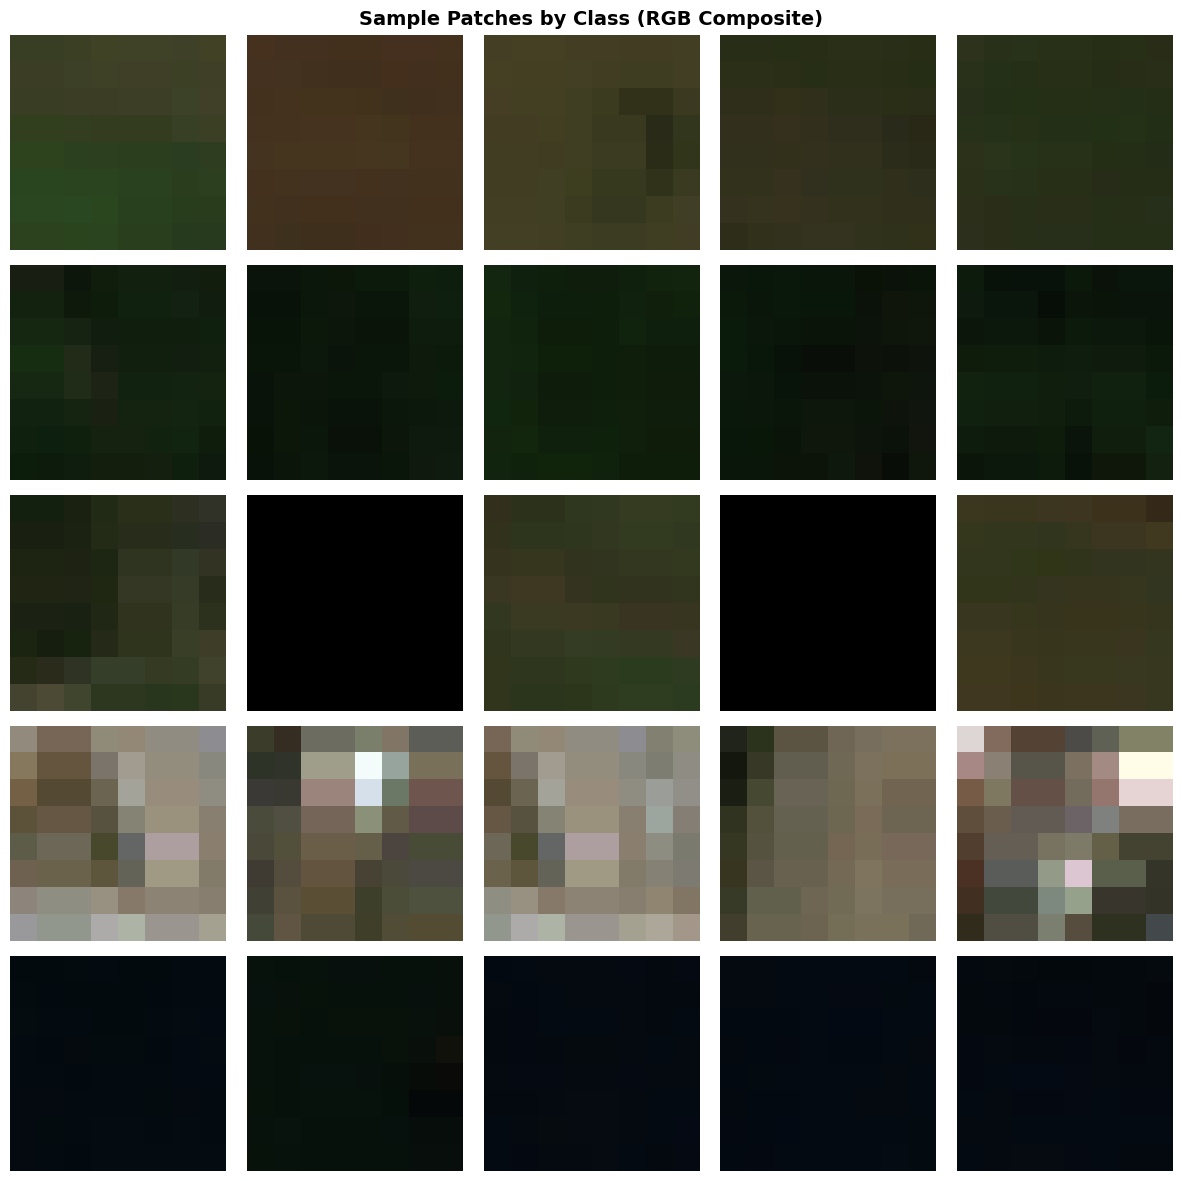

✓ Saved: figures/week3/sample_patches_by_class.png


In [36]:
# Visualize sample patches
fig, axes = plt.subplots(5, 5, figsize=(12, 12))

for class_idx, class_name in enumerate(CLASS_NAMES):
    # Find patches of this class
    class_mask = y_train == class_idx
    class_indices = np.where(class_mask)[0]
    
    # Sample 5 random patches
    sample_indices = np.random.choice(class_indices, min(5, len(class_indices)), replace=False)
    
    for col, idx in enumerate(sample_indices):
        ax = axes[class_idx, col]
        
        # Create RGB composite (bands 2,1,0 = R,G,B)
        patch = X_train_norm[idx]
        rgb = patch[:, :, [2, 1, 0]]  # Red, Green, Blue bands
        rgb = np.clip(rgb * 3, 0, 1)  # Enhance brightness
        
        ax.imshow(rgb)
        
        if col == 0:
            ax.set_ylabel(class_name, fontsize=10, fontweight='bold')
        ax.axis('off')

plt.suptitle('Sample Patches by Class (RGB Composite)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig(FIGURES_DIR / 'sample_patches_by_class.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Saved: figures/week3/sample_patches_by_class.png")

In [37]:
# Verify class distribution
unique, counts = np.unique(y_train, return_counts=True)
print("\nTraining set class distribution:")
for class_idx, count in zip(unique, counts):
    pct = count / len(y_train) * 100
    print(f"  {CLASS_NAMES[class_idx]:12s}: {count:3d} ({pct:.1f}%)")

unique, counts = np.unique(y_val, return_counts=True)
print("\nValidation set class distribution:")
for class_idx, count in zip(unique, counts):
    pct = count / len(y_val) * 100
    print(f"  {CLASS_NAMES[class_idx]:12s}: {count:3d} ({pct:.1f}%)")


Training set class distribution:
  Agriculture :  84 (28.0%)
  Forest      :  38 (12.7%)
  Parcels     :  77 (25.7%)
  Urban       :  70 (23.3%)
  Water       :  31 (10.3%)

Validation set class distribution:
  Agriculture :  21 (28.0%)
  Forest      :  10 (13.3%)
  Parcels     :  19 (25.3%)
  Urban       :  17 (22.7%)
  Water       :   8 (10.7%)


## Part 3: Build CNN Architecture

Design a CNN suitable for small 8×8 patches with 6 spectral bands.

In [38]:
def create_simple_cnn(input_shape=(8, 8, 6), num_classes=5):
    """
    Create a simple CNN for 8×8 patch classification.
    
    Architecture:
    - Conv2D(32, 3×3) → BatchNorm → ReLU → MaxPool(2×2)  [8×8 → 4×4]
    - Conv2D(64, 3×3) → BatchNorm → ReLU → MaxPool(2×2)  [4×4 → 2×2]
    - Flatten → Dense(128) → Dropout(0.5) → Dense(num_classes)
    
    Rationale:
    - Small patches require shallow network
    - BatchNorm stabilizes training
    - Dropout prevents overfitting (limited data)
    - MaxPool reduces spatial dimensions efficiently
    """
    model = models.Sequential([
        # Input layer
        layers.Input(shape=input_shape),
        
        # Conv Block 1
        layers.Conv2D(32, (3, 3), padding='same', activation=None),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.MaxPooling2D((2, 2)),  # 8×8 → 4×4
        
        # Conv Block 2
        layers.Conv2D(64, (3, 3), padding='same', activation=None),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.MaxPooling2D((2, 2)),  # 4×4 → 2×2
        
        # Dense layers
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax')
    ], name='SimpleCNN')
    
    return model

# Create model
model = create_simple_cnn(input_shape=(8, 8, 6), num_classes=5)

# Print summary
model.summary()

Model: "SimpleCNN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)               │ (None, 8, 8, 32)       │         1,760 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 8, 8, 32)       │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 8, 8, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 4, 4, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 4, 4, 64)       │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 4, 4, 64)       │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 4, 4, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 2, 2, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 54,181 (211.64 KB)

 Trainable params: 53,989 (210.89 KB)

 Non-trainable params: 192 (768.00 B)

In [39]:
# Count parameters
total_params = model.count_params()
print(f"\nTotal parameters: {total_params:,}")

# Verify with dummy input
dummy_input = np.random.randn(1, 8, 8, 6).astype(np.float32)
dummy_output = model(dummy_input, training=False)
print(f"\n✓ Test forward pass successful")
print(f"  Input shape: {dummy_input.shape}")
print(f"  Output shape: {dummy_output.shape}")
print(f"  Output sum (should ≈1.0): {dummy_output.numpy().sum():.6f}")


Total parameters: 54,181

✓ Test forward pass successful
  Input shape: (1, 8, 8, 6)
  Output shape: (1, 5)
  Output sum (should ≈1.0): 1.000000


## Part 4: Configure Training

In [40]:
# Training configuration
config = {
    'num_epochs': 50,
    'batch_size': 32,
    'learning_rate': 0.001,
    'early_stopping_patience': 10,
    'reduce_lr_patience': 5,
    'model_save_path': str(MODELS_DIR / 'best_model.h5'),
    'seed': SEED
}

print("Training configuration:")
for key, value in config.items():
    print(f"  {key}: {value}")

Training configuration:
  num_epochs: 50
  batch_size: 32
  learning_rate: 0.001
  early_stopping_patience: 10
  reduce_lr_patience: 5
  model_save_path: /Users/mstone14/QGIS/GeoAI_Class/github/earth-vision-portfolio/models/week3/best_model.h5
  seed: 42


In [41]:
# Compile model
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=config['learning_rate']),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

print("✓ Model compiled with:")
print(f"  Optimizer: Adam (lr={config['learning_rate']})")
print(f"  Loss: sparse_categorical_crossentropy")
print(f"  Metrics: accuracy")

✓ Model compiled with:
  Optimizer: Adam (lr=0.001)
  Loss: sparse_categorical_crossentropy
  Metrics: accuracy


In [42]:
# Setup callbacks
callback_list = [
    # Save best model
    callbacks.ModelCheckpoint(
        filepath=config['model_save_path'],
        monitor='val_accuracy',
        mode='max',
        save_best_only=True,
        verbose=1
    ),
    
    # Early stopping
    callbacks.EarlyStopping(
        monitor='val_loss',
        patience=config['early_stopping_patience'],
        restore_best_weights=True,
        verbose=1
    ),
    
    # Reduce learning rate on plateau
    callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=config['reduce_lr_patience'],
        min_lr=1e-7,
        verbose=1
    )
]

print("✓ Callbacks configured:")
print("  - ModelCheckpoint (save best val_accuracy)")
print(f"  - EarlyStopping (patience={config['early_stopping_patience']})")
print(f"  - ReduceLROnPlateau (patience={config['reduce_lr_patience']})")

✓ Callbacks configured:
  - ModelCheckpoint (save best val_accuracy)
  - EarlyStopping (patience=10)
  - ReduceLROnPlateau (patience=5)


## Part 5: Train Model

Train the CNN for up to 50 epochs with early stopping.

In [43]:
# Train model
print("\n" + "="*80)
print("STARTING TRAINING")
print("="*80)
print(f"Training samples: {len(X_train_norm)}")
print(f"Validation samples: {len(X_val_norm)}")
print(f"Batch size: {config['batch_size']}")
print(f"Max epochs: {config['num_epochs']}")
print("="*80 + "\n")

history = model.fit(
    X_train_norm, y_train,
    batch_size=config['batch_size'],
    epochs=config['num_epochs'],
    validation_data=(X_val_norm, y_val),
    callbacks=callback_list,
    verbose=1
)

print("\n" + "="*80)
print("TRAINING COMPLETE")
print("="*80)


STARTING TRAINING
Training samples: 300
Validation samples: 75
Batch size: 32
Max epochs: 50

Epoch 1/50
 1/10 ━━━━━━━━━━━━━━━━━━━━ 7s 877ms/step - accuracy: 0.3125 - loss: 1.8441
Epoch 1: val_accuracy improved from None to 0.45333, saving model to /Users/mstone14/QGIS/GeoAI_Class/github/earth-vision-portfolio/models/week3/best_model.h5


10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.5367 - loss: 1.2622 - val_accuracy: 0.4533 - val_loss: 1.5397 - learning_rate: 0.0010
Epoch 2/50
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.6250 - loss: 0.7981
Epoch 2: val_accuracy improved from 0.45333 to 0.53333, saving model to /Users/mstone14/QGIS/GeoAI_Class/github/earth-vision-portfolio/models/week3/best_model.h5


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6267 - loss: 0.8404 - val_accuracy: 0.5333 - val_loss: 1.5055 - learning_rate: 0.0010
Epoch 3/50
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.6875 - loss: 0.6712
Epoch 3: val_accuracy did not improve from 0.53333
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7267 - loss: 0.6423 - val_accuracy: 0.3467 - val_loss: 1.4977 - learning_rate: 0.0010
Epoch 4/50
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7812 - loss: 0.5826
Epoch 4: val_accuracy did not improve from 0.53333
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7300 - loss: 0.5904 - val_accuracy: 0.4533 - val_loss: 1.4782 - learning_rate: 0.0010
Epoch 5/50
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7188 - loss: 0.5193
Epoch 5: val_accuracy did not improve from 0.53333
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7467 - loss: 0.5448 - val_accuracy: 0.3333 - val_loss: 1.4697 - learning_rate: 0.0010
Epoch 6/50
 1/10 ━━━━━━━━━━━━━━━━━━━

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9667 - loss: 0.0852 - val_accuracy: 0.5600 - val_loss: 1.0070 - learning_rate: 0.0010
Epoch 32/50
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 1.0000 - loss: 0.0558
Epoch 32: val_accuracy did not improve from 0.56000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9800 - loss: 0.0681 - val_accuracy: 0.3867 - val_loss: 1.0355 - learning_rate: 0.0010
Epoch 33/50
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 1.0000 - loss: 0.0827
Epoch 33: val_accuracy did not improve from 0.56000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9900 - loss: 0.0626 - val_accuracy: 0.3600 - val_loss: 1.0450 - learning_rate: 0.0010
Epoch 34/50
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9375 - loss: 0.1263
Epoch 34: val_accuracy did not improve from 0.56000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9700 - loss: 0.0859 - val_accuracy: 0.5467 - val_loss: 0.9536 - learning_rate: 0.0010
Epoch 35/50
 1/10 ━━━━━━━━━━━━

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9700 - loss: 0.0925 - val_accuracy: 0.5867 - val_loss: 0.8672 - learning_rate: 0.0010
Epoch 36/50
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 1.0000 - loss: 0.0609
Epoch 36: val_accuracy improved from 0.58667 to 0.70667, saving model to /Users/mstone14/QGIS/GeoAI_Class/github/earth-vision-portfolio/models/week3/best_model.h5


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9833 - loss: 0.0725 - val_accuracy: 0.7067 - val_loss: 0.7400 - learning_rate: 0.0010
Epoch 37/50
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9375 - loss: 0.1233
Epoch 37: val_accuracy did not improve from 0.70667
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9833 - loss: 0.0636 - val_accuracy: 0.5200 - val_loss: 0.7946 - learning_rate: 0.0010
Epoch 38/50
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 1.0000 - loss: 0.0885
Epoch 38: val_accuracy improved from 0.70667 to 0.76000, saving model to /Users/mstone14/QGIS/GeoAI_Class/github/earth-vision-portfolio/models/week3/best_model.h5


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9900 - loss: 0.0580 - val_accuracy: 0.7600 - val_loss: 0.6248 - learning_rate: 0.0010
Epoch 39/50
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 1.0000 - loss: 0.0352
Epoch 39: val_accuracy did not improve from 0.76000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9967 - loss: 0.0431 - val_accuracy: 0.6667 - val_loss: 0.7371 - learning_rate: 0.0010
Epoch 40/50
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 1.0000 - loss: 0.0333
Epoch 40: val_accuracy did not improve from 0.76000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9867 - loss: 0.0443 - val_accuracy: 0.5067 - val_loss: 0.8219 - learning_rate: 0.0010
Epoch 41/50
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9688 - loss: 0.0764
Epoch 41: val_accuracy did not improve from 0.76000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9900 - loss: 0.0351 - val_accuracy: 0.6933 - val_loss: 0.6276 - learning_rate: 0.0010
Epoch 42/50
 1/10 ━━━━━━━━━━━━

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9833 - loss: 0.0459 - val_accuracy: 0.8000 - val_loss: 0.5569 - learning_rate: 0.0010
Epoch 44/50
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9688 - loss: 0.0434
Epoch 44: val_accuracy did not improve from 0.80000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9933 - loss: 0.0364 - val_accuracy: 0.7467 - val_loss: 0.6178 - learning_rate: 0.0010
Epoch 45/50
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9688 - loss: 0.0554
Epoch 45: val_accuracy did not improve from 0.80000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9867 - loss: 0.0360 - val_accuracy: 0.7867 - val_loss: 0.4977 - learning_rate: 0.0010
Epoch 46/50
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 1.0000 - loss: 0.0262
Epoch 46: val_accuracy improved from 0.80000 to 0.81333, saving model to /Users/mstone14/QGIS/GeoAI_Class/github/earth-vision-portfolio/models/week3/best_model.h5


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9967 - loss: 0.0239 - val_accuracy: 0.8133 - val_loss: 0.4804 - learning_rate: 0.0010
Epoch 47/50
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 1.0000 - loss: 0.0263
Epoch 47: val_accuracy did not improve from 0.81333
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9833 - loss: 0.0434 - val_accuracy: 0.6933 - val_loss: 0.5950 - learning_rate: 0.0010
Epoch 48/50
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 1.0000 - loss: 0.0581
Epoch 48: val_accuracy improved from 0.81333 to 0.86667, saving model to /Users/mstone14/QGIS/GeoAI_Class/github/earth-vision-portfolio/models/week3/best_model.h5


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9900 - loss: 0.0334 - val_accuracy: 0.8667 - val_loss: 0.3087 - learning_rate: 0.0010
Epoch 49/50
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 1.0000 - loss: 0.0195
Epoch 49: val_accuracy did not improve from 0.86667
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9933 - loss: 0.0325 - val_accuracy: 0.7733 - val_loss: 0.4009 - learning_rate: 0.0010
Epoch 50/50
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 1.0000 - loss: 0.0376
Epoch 50: val_accuracy did not improve from 0.86667
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9867 - loss: 0.0400 - val_accuracy: 0.8267 - val_loss: 0.3998 - learning_rate: 0.0010
Restoring model weights from the end of the best epoch: 48.

TRAINING COMPLETE


In [44]:
# Save training history
history_dict = {
    'train_loss': [float(x) for x in history.history['loss']],
    'train_accuracy': [float(x) for x in history.history['accuracy']],
    'val_loss': [float(x) for x in history.history['val_loss']],
    'val_accuracy': [float(x) for x in history.history['val_accuracy']]
}

with open(REPORTS_DIR / 'training_history.json', 'w') as f:
    json.dump(history_dict, f, indent=2)

print(f"✓ Saved training history to: {REPORTS_DIR / 'training_history.json'}")

✓ Saved training history to: /Users/mstone14/QGIS/GeoAI_Class/github/earth-vision-portfolio/reports/week3/training_history.json


## Part 6: Evaluate Model Performance

In [45]:
# Load best model
model = keras.models.load_model(config['model_save_path'])
print(f"✓ Loaded best model from: {config['model_save_path']}")

✓ Loaded best model from: /Users/mstone14/QGIS/GeoAI_Class/github/earth-vision-portfolio/models/week3/best_model.h5


In [46]:
# Generate predictions
y_pred_proba = model.predict(X_val_norm, verbose=0)
y_pred = np.argmax(y_pred_proba, axis=1)

print(f"✓ Generated predictions on {len(y_val)} validation samples")

✓ Generated predictions on 75 validation samples


In [47]:
# Calculate overall metrics
accuracy = accuracy_score(y_val, y_pred)
precision, recall, f1, support = precision_recall_fscore_support(
    y_val, y_pred, average='weighted'
)

print("\n" + "="*80)
print("OVERALL PERFORMANCE METRICS")
print("="*80)
print(f"Accuracy:  {accuracy*100:.2f}%")
print(f"Precision: {precision:.3f}")
print(f"Recall:    {recall:.3f}")
print(f"F1 Score:  {f1:.3f}")
print("="*80)


OVERALL PERFORMANCE METRICS
Accuracy:  86.67%
Precision: 0.898
Recall:    0.867
F1 Score:  0.867


In [48]:
# Per-class metrics
precision_pc, recall_pc, f1_pc, support_pc = precision_recall_fscore_support(
    y_val, y_pred, average=None
)

print("\nPER-CLASS METRICS")
print("-" * 80)
print(f"{'Class':12s} {'Precision':>10s} {'Recall':>10s} {'F1':>10s} {'Support':>10s}")
print("-" * 80)

for i, class_name in enumerate(CLASS_NAMES):
    print(f"{class_name:12s} {precision_pc[i]:10.3f} {recall_pc[i]:10.3f} {f1_pc[i]:10.3f} {support_pc[i]:10d}")

print("-" * 80)


PER-CLASS METRICS
--------------------------------------------------------------------------------
Class         Precision     Recall         F1    Support
--------------------------------------------------------------------------------
Agriculture       0.895      0.810      0.850         21
Forest            1.000      1.000      1.000         10
Parcels           1.000      0.684      0.812         19
Urban             0.680      1.000      0.810         17
Water             1.000      1.000      1.000          8
--------------------------------------------------------------------------------


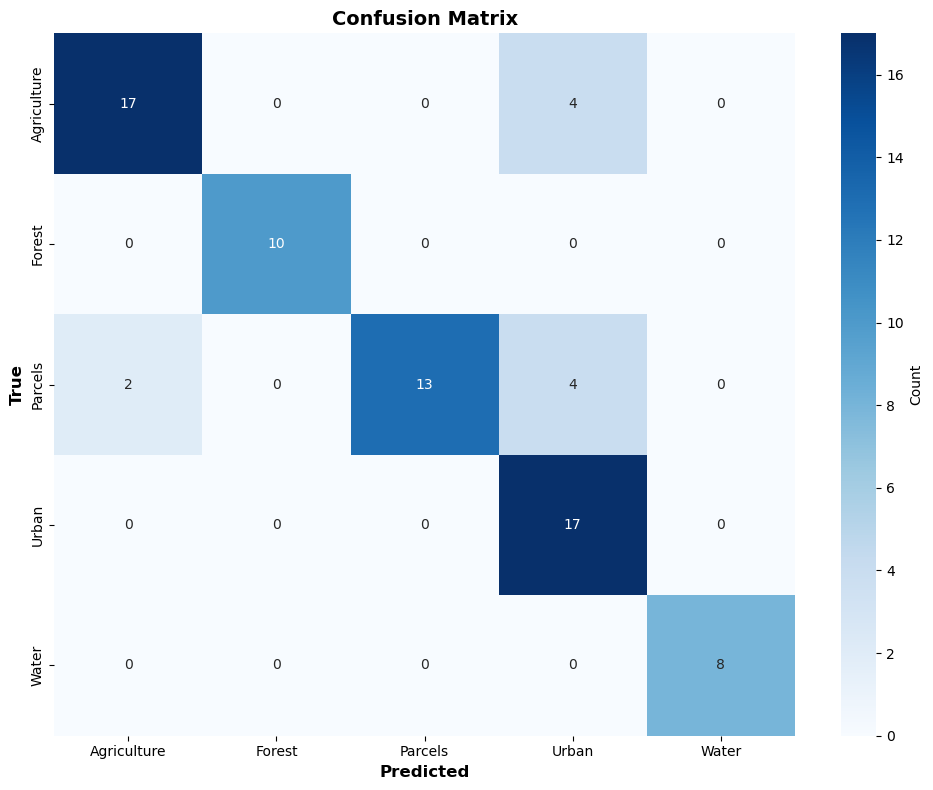

✓ Saved: /Users/mstone14/QGIS/GeoAI_Class/github/earth-vision-portfolio/figures/week3/confusion_matrix.png


In [49]:
# Confusion matrix
cm = confusion_matrix(y_val, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=CLASS_NAMES, yticklabels=CLASS_NAMES,
            cbar_kws={'label': 'Count'})
plt.xlabel('Predicted', fontsize=12, fontweight='bold')
plt.ylabel('True', fontsize=12, fontweight='bold')
plt.title('Confusion Matrix', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig(FIGURES_DIR / 'confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"✓ Saved: {FIGURES_DIR / 'confusion_matrix.png'}")

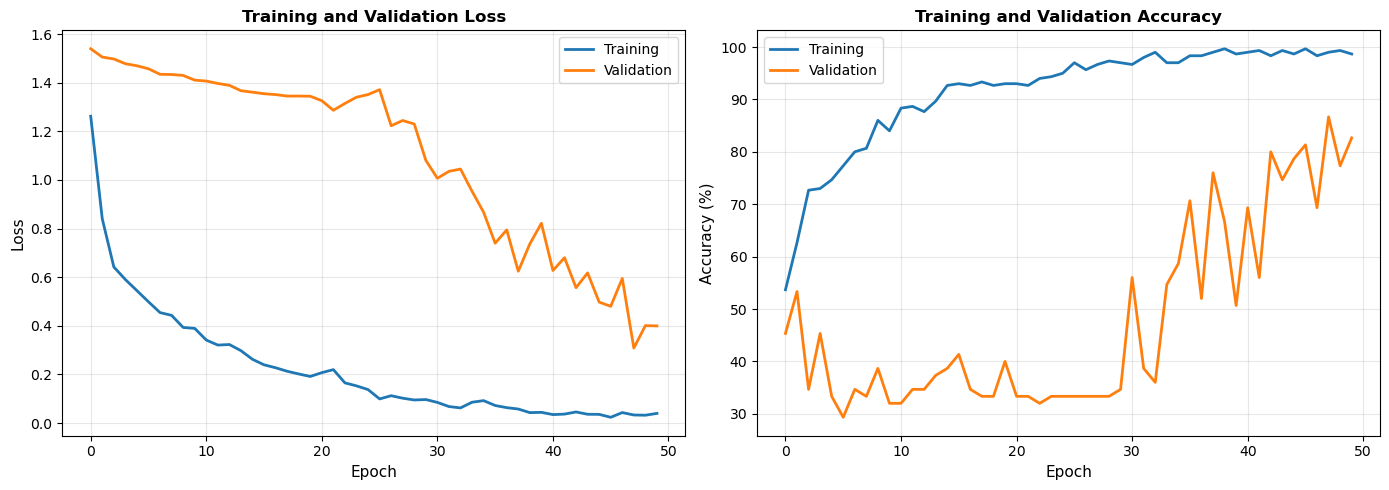

✓ Saved: /Users/mstone14/QGIS/GeoAI_Class/github/earth-vision-portfolio/figures/week3/training_curves.png


In [50]:
# Training curves
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Loss curves
ax1.plot(history.history['loss'], label='Training', linewidth=2)
ax1.plot(history.history['val_loss'], label='Validation', linewidth=2)
ax1.set_xlabel('Epoch', fontsize=11)
ax1.set_ylabel('Loss', fontsize=11)
ax1.set_title('Training and Validation Loss', fontsize=12, fontweight='bold')
ax1.legend(fontsize=10)
ax1.grid(True, alpha=0.3)

# Accuracy curves
ax2.plot([x*100 for x in history.history['accuracy']], label='Training', linewidth=2)
ax2.plot([x*100 for x in history.history['val_accuracy']], label='Validation', linewidth=2)
ax2.set_xlabel('Epoch', fontsize=11)
ax2.set_ylabel('Accuracy (%)', fontsize=11)
ax2.set_title('Training and Validation Accuracy', fontsize=12, fontweight='bold')
ax2.legend(fontsize=10)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(FIGURES_DIR / 'training_curves.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"✓ Saved: {FIGURES_DIR / 'training_curves.png'}")

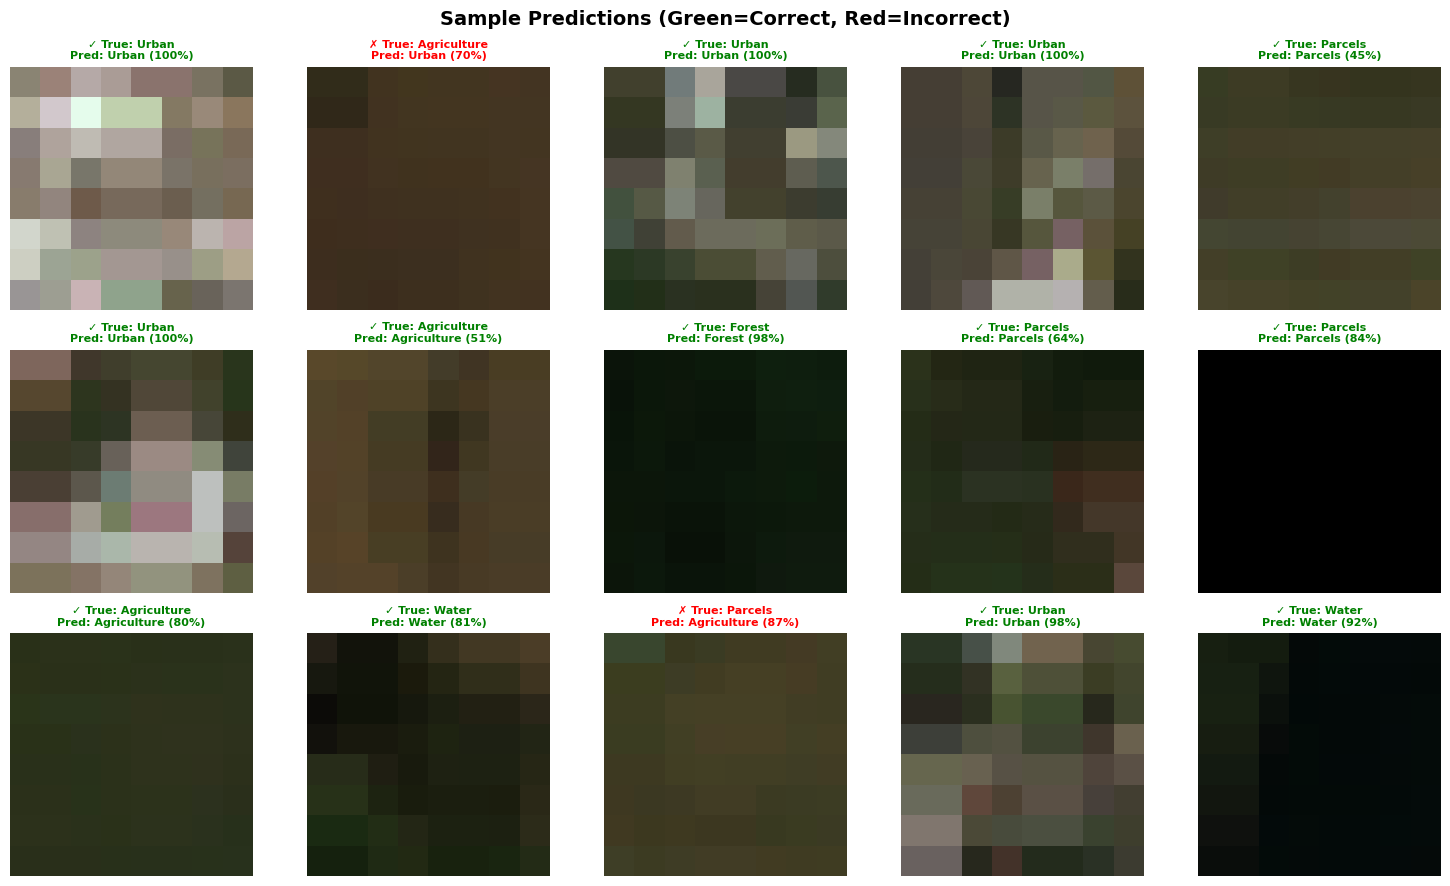

✓ Saved: /Users/mstone14/QGIS/GeoAI_Class/github/earth-vision-portfolio/figures/week3/prediction_samples.png


In [51]:
# Sample predictions
fig, axes = plt.subplots(3, 5, figsize=(15, 9))

# Sample 15 random validation indices
sample_indices = np.random.choice(len(y_val), 15, replace=False)

for idx, ax_idx in enumerate(sample_indices):
    row = idx // 5
    col = idx % 5
    ax = axes[row, col]
    
    # Get patch and labels
    patch = X_val_norm[ax_idx]
    true_label = y_val[ax_idx]
    pred_label = y_pred[ax_idx]
    confidence = y_pred_proba[ax_idx, pred_label] * 100
    
    # RGB composite
    rgb = patch[:, :, [2, 1, 0]]  # R,G,B
    rgb = np.clip(rgb * 3, 0, 1)
    
    ax.imshow(rgb)
    
    # Color title based on correctness
    if true_label == pred_label:
        color = 'green'
        marker = '✓'
    else:
        color = 'red'
        marker = '✗'
    
    ax.set_title(f"{marker} True: {CLASS_NAMES[true_label]}\nPred: {CLASS_NAMES[pred_label]} ({confidence:.0f}%)",
                fontsize=8, color=color, fontweight='bold')
    ax.axis('off')

plt.suptitle('Sample Predictions (Green=Correct, Red=Incorrect)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig(FIGURES_DIR / 'prediction_samples.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"✓ Saved: {FIGURES_DIR / 'prediction_samples.png'}")

## Part 7: Model Interpretation

Visualize what the CNN learned.

In [52]:
# Save metrics to JSON
metrics = {
    'overall': {
        'accuracy': float(accuracy),
        'precision': float(precision),
        'recall': float(recall),
        'f1': float(f1)
    },
    'per_class': {
        CLASS_NAMES[i]: {
            'precision': float(precision_pc[i]),
            'recall': float(recall_pc[i]),
            'f1': float(f1_pc[i]),
            'support': int(support_pc[i])
        } for i in range(len(CLASS_NAMES))
    },
    'confusion_matrix': cm.tolist(),
    'training_history': history_dict
}

with open(REPORTS_DIR / 'metrics.json', 'w') as f:
    json.dump(metrics, f, indent=2)

print(f"✓ Saved metrics to: {REPORTS_DIR / 'metrics.json'}")

✓ Saved metrics to: /Users/mstone14/QGIS/GeoAI_Class/github/earth-vision-portfolio/reports/week3/metrics.json


## Summary

Trained CNN model for land cover classification on Los Lagos, Chile dataset.

**Model Performance:**
- Validation Accuracy: See output above
- All deliverables saved to:
  - `models/week3/best_model.h5`
  - `figures/week3/` (confusion matrix, curves, samples)
  - `reports/week3/` (metrics JSON, history)

**Next Steps:**
1. Review visualizations to understand model behavior
2. Analyze misclassifications in confusion matrix
3. Consider data augmentation if overfitting
4. Document findings in model card and ethics reflection